# Classifiez automatiquement des biens de consommation - Image Features extraction

Pascaline Grondein

Début : 04/07/2022

<i/>Vous êtes Data Scientist au sein de l’entreprise "Place de marché”, qui souhaite lancer une marketplace e-commerce.</i>

<i/>Sur la place de marché, des vendeurs proposent des articles à des acheteurs en postant une photo et une description.</i>

<i/>Pour l'instant, l'attribution de la catégorie d'un article est effectuée manuellement par les vendeurs, et est donc peu fiable. De plus, le volume des articles est pour l’instant très petit.</i>

<i/>Pour rendre l’expérience utilisateur des vendeurs (faciliter la mise en ligne de nouveaux articles) et des acheteurs (faciliter la recherche de produits) la plus fluide possible, et dans l'optique d'un passage à l'échelle, il devient nécessaire d'automatiser cette tâche.</i>

### Table of Contents

* [I. Preprocessing](#chapter1)
    * [1. Récupération des labels](#section_1_1)
    * [2. Traitements locaux : une image](#section_1_2)
        * [1. Greyscale](#section_1_2_1)
        * [2. Egalisation](#section_1_2_2)
        * [3. Etirement d'histogramme](#section_1_2_3)
        * [4. Mean filter](#section_1_2_4)
    * [3. Traitements non locaux : une image](#section_1_3)
    * [4. Fonction prétraitement](#section_1_4)
* [II. Bag of features : Sift, ORB](#chapter2)
    * [1. SIFT](#section_2_1)
        * [1. Traitement SIFT](#section_2_1_1)
        * [2. Réduction, Clustering, Visualisation and ARI](#section_2_1_2)
    * [2. ORB](#section_2_2)
        * [1. Traitement orb](#section_2_2_1)
        * [2. Réduction, Clustering, Visualisation and ARI](#section_2_2_2)
* [III. CNN transfer learning](#chapter3)
    * [1. VGG16](#section_3_1)
    * [2. InceptionV3](#section_3_2)

In [1]:
import os, sys, time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
%matplotlib inline
from os import listdir
import random
from sklearn import cluster, metrics

import PIL
from PIL import Image, ImageOps
import skimage
from skimage import io 
from skimage.io import imshow, imread
from skimage.color import rgb2hsv, rgb2gray, rgb2yuv
from skimage import color, exposure, transform
from skimage.exposure import histogram, cumulative_distribution, equalize_hist
from skimage import img_as_ubyte, img_as_uint
from keras.layers import Dense, Activation, Flatten
from PIL import ImageFilter

#SIFT
import cv2

#ACP
from ACP import *
from sklearn.decomposition import PCA

#visualization
from sklearn import decomposition
from sklearn import preprocessing
from sklearn import cluster, metrics
from sklearn import manifold, decomposition

#CNN Transfer Learning
import keras
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.utils import load_img

import logging
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

import warnings
warnings.filterwarnings("ignore")

# Data

In [2]:
path = 'C:/Users/pgron/Jupyter/P6/data/source/'
fn = path + 'df_image.csv'

df = pd.read_csv(fn)
df.head(1)

,uniq_id,image,true_label
0,55b85ea15a1536d46b7190ad6fff8ce7,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing


In [3]:
path = 'C:/Users/pgron/Jupyter/P6/data/source/Images/'
list_photos = df['image'].tolist()

print('La dataset comprend {} images.'.format(len(list_photos)))

La dataset comprend 1050 images.


# FUNCTIONS 

In [4]:
def list_fct(name) :
    list_image_name = [list_photos[i] for i in range(len(df)) if df["true_label"][i]==name]
    return list_image_name

In [5]:
# Reduction    
def reduc(features, n_comp) :
    
    #ACP
    feat_pca = features
    pca = PCA(n_components = n_comp)
    pca_res = pca.fit_transform(feat_pca)
    display_scree_plot(pca)
    
    #tSNE
    feat_tsne = features
    tsne = manifold.TSNE(n_components = 2, perplexity = 30, n_iter = 2000, 
                         init = 'random', learning_rate = 200, random_state = 42)
    X_tsne = tsne.fit_transform(feat_tsne)
    
    return X_tsne, pca_res

# Clustering par kmeans
def kmeans_(df, X) :
    
    #True labels
    true_labels = list(set(df['true_label']))
    nb_labels = len(true_labels)
    #print('Number of true labels :', nb_labels)
    
    # Kmeans
    cls = cluster.KMeans(n_clusters = nb_labels, n_init = 100, random_state = 42)
    cls.fit(X)
    cl_labels = cls.labels_
    
    return cl_labels


# Visualisation w/ Tsne (true labels or kmeans clusters)
def TSNE_visu_ARI(df, X_tsne, cl_labels) :
    
    #True labels
    true_labels = list(set(df['true_label']))
    true_num_labels = [(true_labels.index(df.iloc[i]['true_label'])) 
                       for i in range(len(df))]
    nb_labels = len(true_labels)
    
    fig = plt.figure(figsize=(15,6))
        
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0], X_tsne[:,1], c = true_num_labels, cmap = 'Set1')
    ax.legend(handles = scatter.legend_elements()[0], labels = true_labels, 
              loc = "best", title = "Catégories")
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.title('Produits par catégories réelles', Fontsize = 20)
    

    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0], X_tsne[:,1], c = cl_labels, cmap = 'Set1')
    ax.legend(handles = scatter.legend_elements()[0], labels = set(cl_labels), 
              loc = "best", title = "Clusters")
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.title('Produits par clusters', Fontsize = 20)
    
    plt.show()
    
    ARI = np.round(metrics.adjusted_rand_score(true_num_labels, cl_labels),4)
    print("ARI : ", ARI)
    print('         ')
    
    return ARI



def min_max(df, precision) : 
    
    maxi = df.max().max()
    mini = df.min().min()
    
    df = df.style.applymap(lambda x: "background-color: red" if x == maxi
                           else "background-color: cyan" if x == mini
                           else "background-color: white").set_precision(precision)
    
    return df

# <a class="anchor" id="chapter1">I. Preprocessing</a>

## <a class="anchor" id="section_1_1">1. Récupération des labels</a> 

In [6]:
df.groupby("true_label").count()

,uniq_id,image
true_label,,
Baby Care,150,150
Beauty and,150,150
Computers,150,150
Home Decor,150,150
Home Furnishing,150,150
Kitchen,150,150
Watches,150,150


Home Furnishing


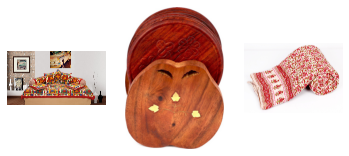

Baby Care


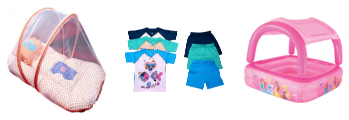

Watches 


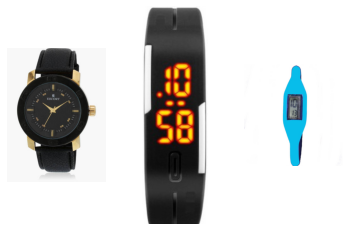

Home Decor


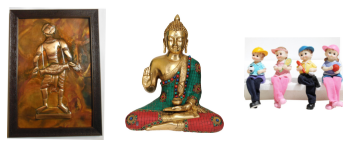

Kitchen 


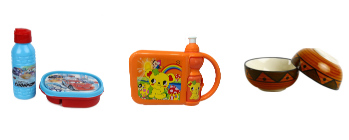

Beauty and


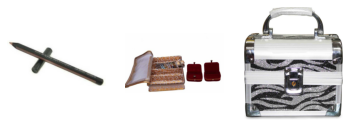

Computers 


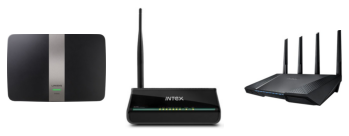

In [7]:
for name in df.true_label.unique() :
    print(name)
    # print("-------")
    for i in range(3):
        plt.subplot(130 + 1 + i)
        filename = path + list_fct(name)[i+10]
        image = imread(filename)
        plt.imshow(image)
        plt.axis("off")
    plt.show()

## <a class="anchor" id="section_1_2">2. Traitements locaux : une Image</a> 

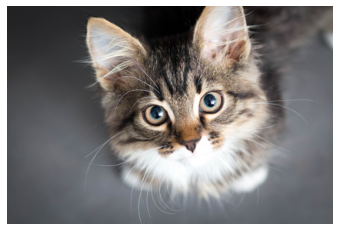

In [8]:
#img = Image.open(path + (random.choice(list_photos)))
img = Image.open('chat.jpeg')
plt.imshow(img)
plt.axis("off")
plt.show()

In [9]:
w, h = img.size
print("Largeur : {} px, hauteur : {} px".format(w, h))

Largeur : 424 px, hauteur : 283 px


In [10]:
print("Format des pixels : {}".format(img.mode))

Format des pixels : RGB


In [11]:
# Récupérer les valeurs de tous les pixels sous forme d'une matrice
img_mat = np.array(img)

# Afficher la taille de la matrice de pixels
print("Taille de la matrice de pixels : {}".format(img_mat.shape))

Taille de la matrice de pixels : (283, 424, 3)


### <a class="anchor" id="section_1_2_1">1. Greyscale</a> 

Il faut convertir l'image en GrayScale avant d'utiliser SIFT.

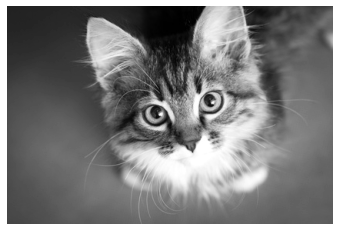

In [12]:
img_gray = img.convert('L')
plt.imshow(img_gray, cmap = 'gray')
plt.axis("off")
plt.show()

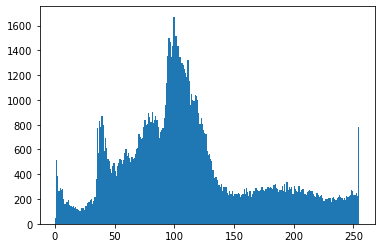

In [13]:
# Charger l'image comme matrice de pixels
img_gray_mat = np.array(img_gray)

n, bins, patches = plt.hist(img_gray_mat.flatten(), bins = range(256))
plt.show()

### <a class="anchor" id="section_1_2_2">2. Egalisation</a>  

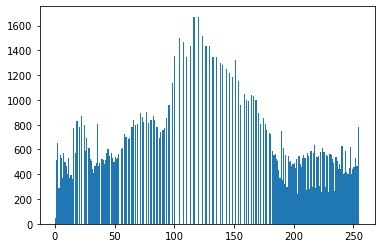

In [14]:
#img_equ = ImageOps.equalize(img_cont, mask = None)
img_equ_mat = cv2.equalizeHist(img_gray_mat)
img_equ = Image.fromarray(img_equ_mat)

#img_equ_mat = np.array(img_equ)
n, bins, patches = plt.hist(img_equ_mat.flatten(), bins = range(256))
plt.show()

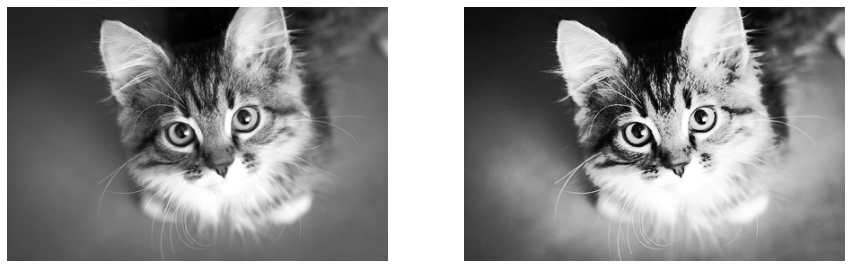

In [15]:
f = plt.figure(figsize = (15,8))
f.add_subplot(1, 2, 1)
plt.imshow(img_gray, cmap = 'gray')
plt.axis("off")
f.add_subplot(1, 2, 2)
plt.imshow(img_equ, cmap = 'gray')
plt.axis("off")
plt.show()

### <a class="anchor" id="section_1_2_3">3. Etirement d'histogramme</a> 

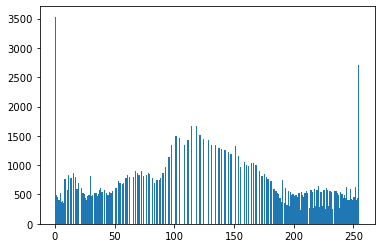

In [16]:
img_cont = ImageOps.autocontrast(img_equ, cutoff = 2, ignore = 2)
img_cont_mat = np.array(img_cont)
n, bins, patches = plt.hist(img_cont_mat.flatten(), bins = range(256))
plt.show()

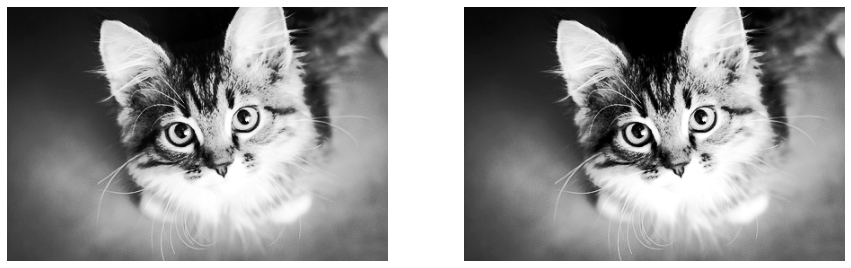

In [17]:
f = plt.figure(figsize = (15,8))
f.add_subplot(1, 2, 1)
plt.imshow(img_equ, cmap = 'gray')
plt.axis("off")
f.add_subplot(1, 2, 2)
plt.imshow(img_cont, cmap = 'gray')
plt.axis("off")
plt.show()

### <a class="anchor" id="section_1_2_4">4. Mean filter</a> 

In [18]:
#img_blur = img_noisy.filter(ImageFilter.BoxBlur(1))

ksize = (5, 5) #kernel size, intensity of the blur
img_blur = cv2.blur(img_cont_mat, ksize)

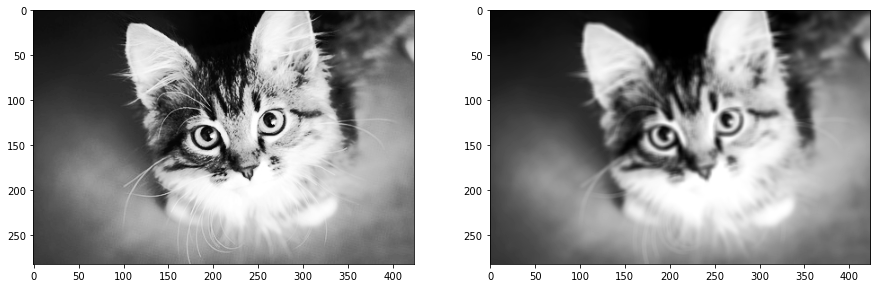

In [19]:
f = plt.figure(figsize = (15,8))
f.add_subplot(1, 2, 1)
plt.imshow(img_equ, cmap = 'gray')
f.add_subplot(1, 2, 2)
plt.imshow(img_blur, cmap = 'gray')
plt.show()

Comparons l'image avant et après traitement : 

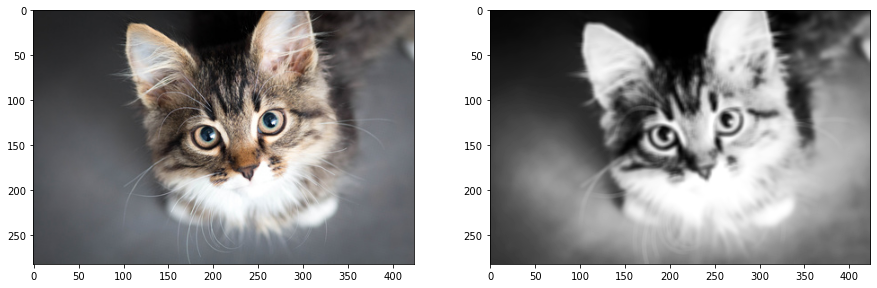

In [20]:
f = plt.figure(figsize = (15,8))
f.add_subplot(1, 2, 1)
plt.imshow(img)
f.add_subplot(1, 2, 2)
plt.imshow(img_blur, cmap = 'gray')
plt.show()

The mean filter is used to blur an image in order to remove noise.

Other possibilities : 

 - Gaussian filter
 - Median filter

## <a class="anchor" id="section_1_3">3. Traitement non-locaux : une image</a> 

Perform image denoising using Non-local Means Denoising algorithm with several computational optimizations. Noise expected to be a gaussian white noise. 

In [21]:
#img = Image.open(path + (random.choice(list_photos)))
img = Image.open('chat.jpeg')

img_mat = np.array(img)
img_gray = img.convert('L')
img_gray_mat = np.array(img_gray)

img_clean_gray = cv2.fastNlMeansDenoising(img_gray_mat, None, 10, 10, 7)
img_clean_color = cv2.fastNlMeansDenoisingColored(img_mat, None, 10, 10, 7, 21)

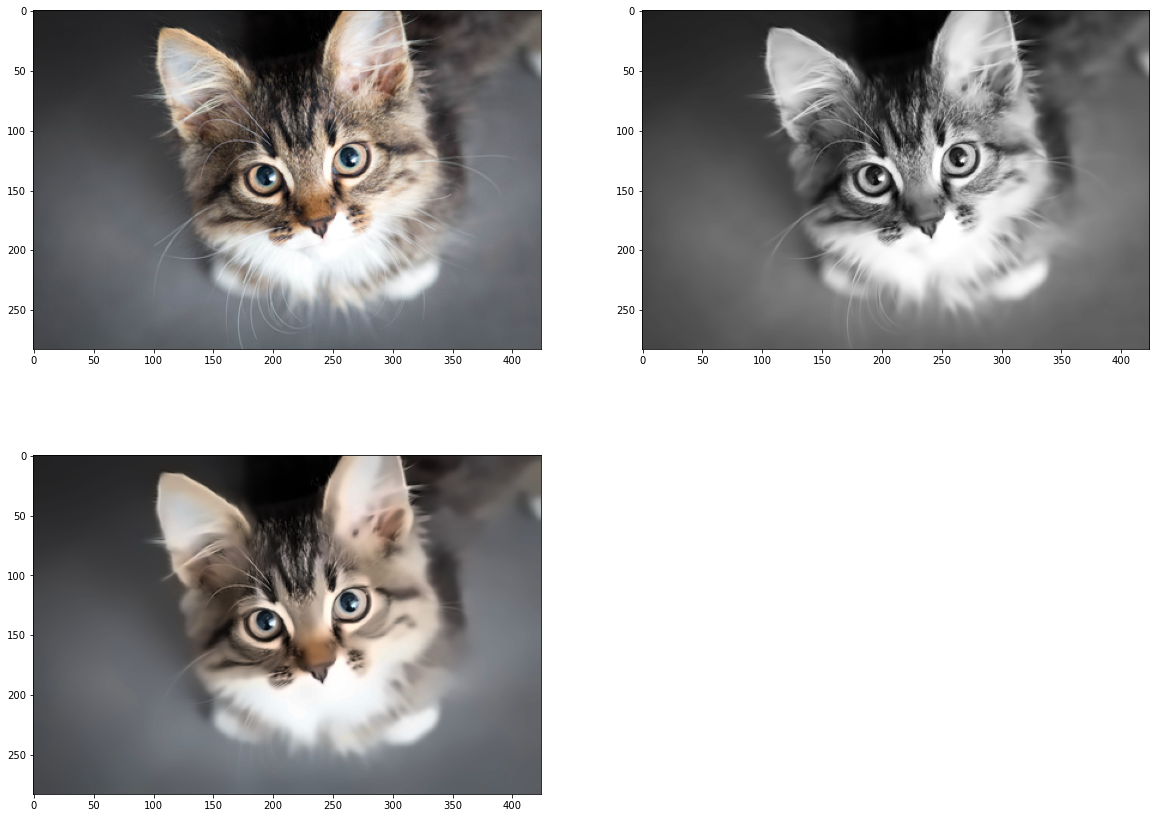

In [22]:
f = plt.figure(figsize = (20,15))
plt.subplot(221),plt.imshow(img)
plt.subplot(222),plt.imshow(img_clean_gray, cmap = 'gray')
plt.subplot(223),plt.imshow(img_clean_color)
plt.show()

##  <a class="anchor" id="section_1_4">4. Fonction prétraitement</a> 

In [23]:
def preprocess(img, pretreat, colors) :
    
    if pretreat == 'global' :
        
        #Gray conversion
        img_gray = img.convert('L')
        
        #Pixel matrix
        img_mat = np.array(img)
        img_gray_mat = np.array(img_gray)
        
        # Global Filter
        img_clean_gray = cv2.fastNlMeansDenoising(img_gray_mat, None, 10, 10, 7)
        img_clean_color = cv2.fastNlMeansDenoisingColored(img_mat, None, 10, 10, 7, 21)
        
        img_clean_gray = np.array(img_clean_gray)
        img_clean_color = np.array(img_clean_color)
        
        if colors == 'gray' :
            return img_clean_gray
        
        else :
            return img_clean_color
    
    if pretreat == 'local' :
        
        #Gray conversion
        img_gray = img.convert('L')
        
        #Equalization
        img_gray_mat = np.array(img_gray)
        img_equ_mat = cv2.equalizeHist(img_gray_mat)
        img_equ = Image.fromarray(img_equ_mat)
        
        #Contrast
        img_cont = ImageOps.autocontrast(img_equ, cutoff = 2, ignore = 2)
        img_cont_mat = np.array(img_cont)
        
        
        #Mean filter
        #img_blur = img_noisy.filter(ImageFilter.BoxBlur(1))
        
        ksize = (5, 5) #kernel size, intensity of the blur
        img_blur = cv2.blur(img_cont_mat, ksize)
        
        
        return img_blur

# <a class="anchor" id="chapter2">II. Bag of features : SIFT, ORB</a>

Pour les méthodes Bag of Features, je vais procéder comme ceci :

 - Créations des descripteurs de chaque image : 
     * Pour chaque image, prétraitement avec la fonction prédédemment définie
     * Création d'une liste de descripteurs par image ("kp_by_img") qui sera utilisée pour réaliser les histogrammes par image
     * Création d'une liste de descripteurs pour l'ensemble des images ("keypoints_all") qui sera utilisé pour créer les clusters de descripteurs
    
 - Création des clusters de descripteurs : la création de clusters de descripteurs permet le comptage pour chaque image du nombre de descripteurs par cluster et surtout de générer les « features » des images via un"bag-of-images"
 - Création des features des images. Pour chaque image 
     * prédiction des numéros de cluster de chaque descripteur
     * création d'un histogramme = comptage pour chaque numéro de cluster du nombre de descripteurs de l'image

Features d'une image = Histogramme d'une image = Comptage pour une image du nombre de descripteurs par cluster

In [26]:
def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des = len(des)
    
    if nb_des == 0 : 
        print("problème histogramme image  : ", image_num)
        
    for i in res :
        hist[i] += 1.0/nb_des
        
    return hist

def im_feat(model) :
    
    keypoints = []
    temps1 = time.time()
    
    # KEYPOINTS GENERATION
    for image_num in range(len(list_photos)) :
    
        if image_num%100 == 0 : print(image_num)
        
        image = Image.open(path + list_photos[image_num])
    
    
        image_ready  = preprocess(image, pretreat = 'local', colors = 'gray')
    
        kp, des = model.detectAndCompute(image_ready, None)
    
        keypoints.append(des)
        
    kp_by_img = np.asarray(keypoints)
    keypoints_all = np.concatenate(kp_by_img, axis = 0)
    print()
    print("Nombre de descripteurs : ", keypoints_all.shape)
    
    
    #KEYPOINTS CLUSTER GENERATION
    k = int(round(np.sqrt(len(keypoints_all)),0))
    print("Nombre de clusters estimés : ", k)
    print("Création de", k, "clusters de descripteurs ...")

    kmeans = cluster.MiniBatchKMeans(n_clusters = k, init_size = 3*k, random_state = 0)
    kmeans.fit(keypoints_all)
    
    
    #IMAGE FEATURES GENERATION
    hist_vectors = []

    for i, image_desc in enumerate(kp_by_img) :
    
        if i%100 == 0 : 
            print(i)  
    
        #calculates the histogram    
        hist = build_histogram(kmeans, image_desc, i) 
    
        #histogram is the feature vector
        hist_vectors.append(hist) 

    im_features = np.asarray(hist_vectors)
    
    
    duration1 = time.time() - temps1
    print("Computation time : ", "%15.2f" % duration1, "secondes")
    
    return im_features

## <a class="anchor" id="section_2_1">1. SIFT</a> 

### <a class="anchor" id="section_2_1_1">1. Traitement SIFT</a>

In [27]:
im_feat_SIFT = im_feat(cv2.SIFT_create())

0
100
200
300
400
500
600
700
800
900
1000

Nombre de descripteurs :  (3624359, 128)
Nombre de clusters estimés :  1904
Création de 1904 clusters de descripteurs ...
0
100
200
300
400
500
600
700
800
900
1000
Computation time :           645.44 secondes


### <a class="anchor" id="section_2_1_3">3. Réduction, Clustering, Visualisation and ARI</a>

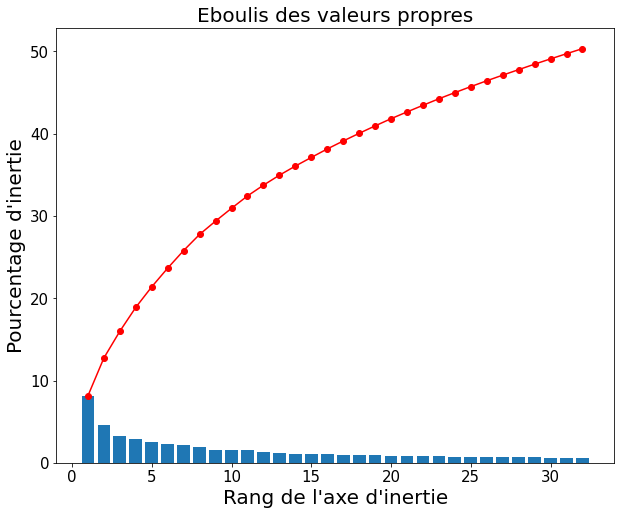

       
                                   --- PCA reduction ----


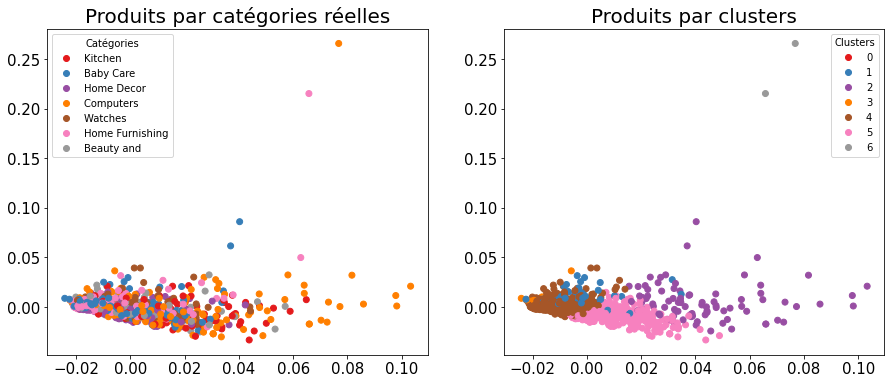

ARI :  0.0335
         
       
       
                                   --- tSNE reduction ----


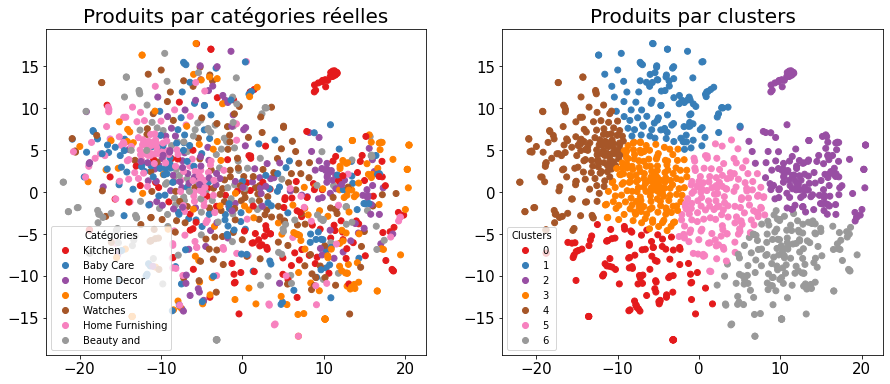

ARI :  0.0422
         
       


,PCA,t-SNE
SIFT,0.0335,0.0422


In [29]:
ari_SIFT = pd.DataFrame()

Xtsne_SIFT, pca_res_SIFT = reduc(im_feat_SIFT, n_comp = 0.5)
    
print('       ')
print('                                   --- PCA reduction ----')
cl_labels_pca =  kmeans_(df, pca_res_SIFT)
ari_SIFT_pca = TSNE_visu_ARI(df, pca_res_SIFT, cl_labels_pca)
print('       ')
    
print('       ')
print('                                   --- tSNE reduction ----')
cl_labels_tsne =  kmeans_(df, Xtsne_SIFT)
ari_SIFT_tsne = TSNE_visu_ARI(df, Xtsne_SIFT, cl_labels_tsne)
print('       ')
    
ari_SIFT = pd.DataFrame(data = {'PCA' : ari_SIFT_pca, 't-SNE' : ari_SIFT_tsne}, index = ['SIFT'])
ari_SIFT

## <a class="anchor" id="section_2_2">2. ORB</a> 

### <a class="anchor" id="section_2_2_1">1. Application ORB</a>

In [31]:
im_feat_ORB = im_feat(cv2.ORB_create())

0
100
200
300
400
500
600
700
800
900
1000

Nombre de descripteurs :  (512286, 32)
Nombre de clusters estimés :  716
Création de 716 clusters de descripteurs ...
0
100
200
300
400
500
600
700
800
900
1000
Computation time :           108.21 secondes


### <a class="anchor" id="section_2_2_2">2. Réduction, Clustering, Visualisation and ARI</a>

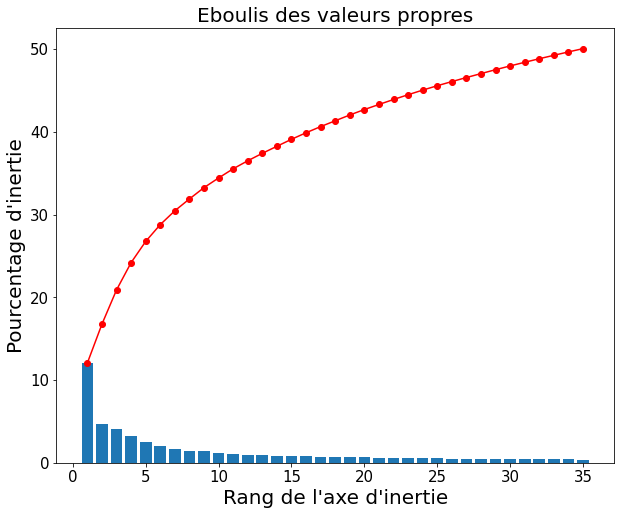

       
                                   --- PCA reduction ----


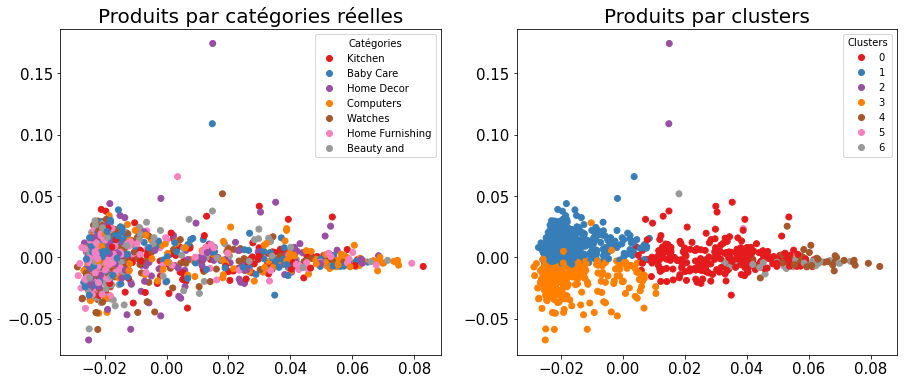

ARI :  0.0211
         
       
       
                                   --- tSNE reduction ----


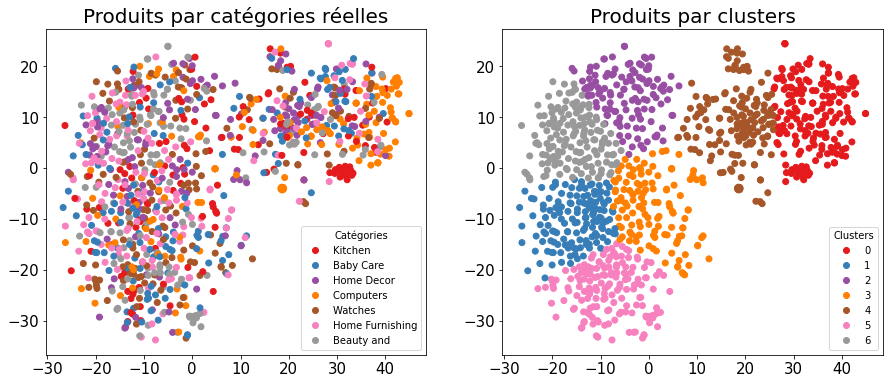

ARI :  0.0327
         
       


,PCA,t-SNE
ORB,0.0211,0.0327


In [32]:
ari_ORB = pd.DataFrame()

Xtsne_ORB, pca_res_ORB = reduc(im_feat_ORB, n_comp = 0.5)
    
print('       ')
print('                                   --- PCA reduction ----')
cl_labels_pca =  kmeans_(df, pca_res_ORB)
ari_ORB_pca = TSNE_visu_ARI(df, pca_res_ORB, cl_labels_pca)
print('       ')
    
print('       ')
print('                                   --- tSNE reduction ----')
cl_labels_tsne =  kmeans_(df, Xtsne_ORB)
ari_ORB_tsne = TSNE_visu_ARI(df, Xtsne_ORB, cl_labels_tsne)
print('       ')
    
ari_ORB = pd.DataFrame(data = {'PCA' : ari_ORB_pca, 't-SNE' : ari_ORB_tsne}, index = ['ORB'])
ari_ORB

# <a class="anchor" id="chapter3">III. CNN Transfer Learning</a>

# <a class="anchor" id="section_3_1">1. VGG16</a> 

The VGG16 model was developed by the Visual Graphics Group (VGG) at Oxford and was described in the 2014 paper titled “Very Deep Convolutional Networks for Large-Scale Image Recognition.”

By default, the model expects color input images to be rescaled to the size of 224×224 squares.

In [33]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.layers import Dense
from keras import Model
import keras.optimizers

In [39]:
#list_photos_ = random.sample(list_photos, 10)

VGG16_prediction = []

# Load model without classifier layers
model = VGG16()

# On entraîne seulement le nouveau classifieur et on ne ré-entraîne pas les autres couches :
for layer in model.layers:
   layer.trainable = False

# Get the output without the classifier layers
x = model.layers[-2].output

# Add a Dense layer on output
#outputs = Dense(dense_l, activation='softmax')(x)

# Define new model
model = Model(inputs = model.inputs, outputs = x)

In [40]:
temps1 = time.time()

for image_num in range(len(list_photos)) :
    
    if image_num%100 == 0 : print(image_num)
        
    img = load_img(path + list_photos[image_num], target_size=(224, 224))
    
    img  = img_to_array(img) 
    img =  img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
    img_ready = preprocess_input(img)
    
    pred = model.predict(img_ready)
    
    VGG16_prediction.append(pred)
    
im_features_VGG16 = np.asarray(VGG16_prediction)
im_features_VGG16.shape = (1050, 4096)
    
duration1 = time.time() - temps1
print("temps de traitement VGG16 descriptor : ", "%15.2f" % duration1, "secondes")

0
1/1 [==============================] - 0s 174ms/step
100
1/1 [==============================] - 0s 164ms/step
200
1/1 [==============================] - 0s 165ms/step
300
1/1 [==============================] - 0s 166ms/step


1/1 [==============================] - 0s 182ms/step
400
1/1 [==============================] - 0s 181ms/step
500
1/1 [==============================] - 0s 178ms/step
600
1/1 [==============================] - 0s 174ms/step


1/1 [==============================] - 0s 174ms/step
700
1/1 [==============================] - 0s 171ms/step
800
1/1 [==============================] - 0s 164ms/step
900
1/1 [==============================] - 0s 174ms/step


1/1 [==============================] - 0s 173ms/step
1000
1/1 [==============================] - 0s 176ms/step
temps de traitement VGG16 descriptor :           242.56 secondes


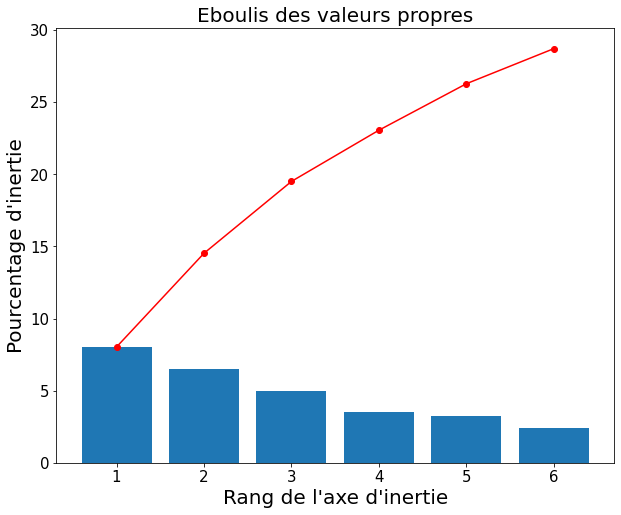

       
                                   --- PCA reduction ----


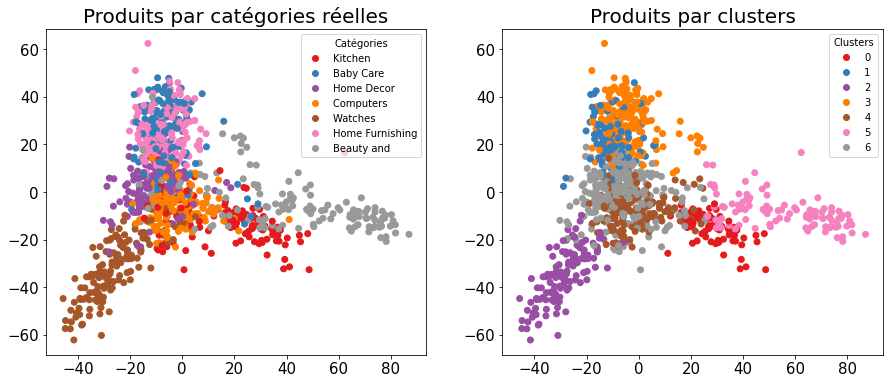

ARI :  0.4461
         
       
       
                                   --- tSNE reduction ----


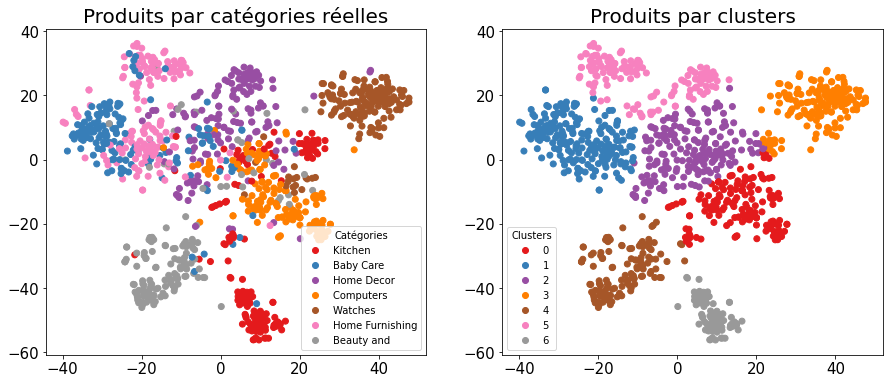

ARI :  0.4393
         
       


In [41]:
ari_VGG16 = pd.DataFrame()

Xtsne_VGG16, pca_res_VGG16 = reduc(im_features_VGG16, n_comp = 6)
    
print('       ')
print('                                   --- PCA reduction ----')
cl_labels_pca =  kmeans_(df, pca_res_VGG16)
ari_VGG16_pca = TSNE_visu_ARI(df, pca_res_VGG16, cl_labels_pca)
print('       ')
    
print('       ')
print('                                   --- tSNE reduction ----')
cl_labels_tsne =  kmeans_(df, Xtsne_VGG16)
ari_VGG16_tsne = TSNE_visu_ARI(df, Xtsne_VGG16, cl_labels_tsne)
print('       ')
    
ari_VGG16 = pd.DataFrame(data = {'PCA' : ari_VGG16_pca, 't-SNE' : ari_VGG16_tsne}, index = ['VGG16'])

## <a class="anchor" id="section_3_2">2. InceptionV3</a> 

In [43]:
from keras.applications.inception_v3 import InceptionV3

In [44]:
#list_photos_ = random.sample(list_photos, 10)

InceptionV3_prediction = []

# Load model without classifier layers
model = InceptionV3()

# On entraîne seulement le nouveau classifieur et on ne ré-entraîne pas les autres couches :
for layer in model.layers:
   layer.trainable = False

# Get the output without the classifier layers
x = model.layers[-2].output

# Add a Dense layer on output
#outputs = Dense(7, activation='softmax')(x)

# Define new model
model = Model(inputs = model.inputs, outputs = x)

In [45]:
temps1 = time.time()

for image_num in range(len(list_photos)) :
    
    if image_num%100 == 0 : print(image_num)
        
    img = load_img(path + list_photos[image_num], target_size=(299, 299))
    
    img  = img_to_array(img) 
    img =  img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
    img_ready = preprocess_input(img)
    
    pred = model.predict(img_ready)
    
    InceptionV3_prediction.append(pred)
    
im_features_IncV3 = np.asarray(InceptionV3_prediction)
im_features_IncV3.shape = (1050, 2048)
    
duration1 = time.time() - temps1
print("temps de traitement InceptionV3 descriptor : ", "%15.2f" % duration1, "secondes")

0
1/1 [==============================] - 0s 98ms/step
100
1/1 [==============================] - 0s 97ms/step
200
1/1 [==============================] - 0s 99ms/step
300
1/1 [==============================] - 0s 97ms/step


1/1 [==============================] - 0s 97ms/step
400
1/1 [==============================] - 0s 102ms/step
500
1/1 [==============================] - 0s 115ms/step
600
1/1 [==============================] - 0s 116ms/step


1/1 [==============================] - 0s 113ms/step
700
1/1 [==============================] - 0s 110ms/step
800
1/1 [==============================] - 0s 103ms/step
900
1/1 [==============================] - 0s 98ms/step


1/1 [==============================] - 0s 95ms/step
1000
1/1 [==============================] - 0s 99ms/step
temps de traitement InceptionV3 descriptor :           178.32 secondes


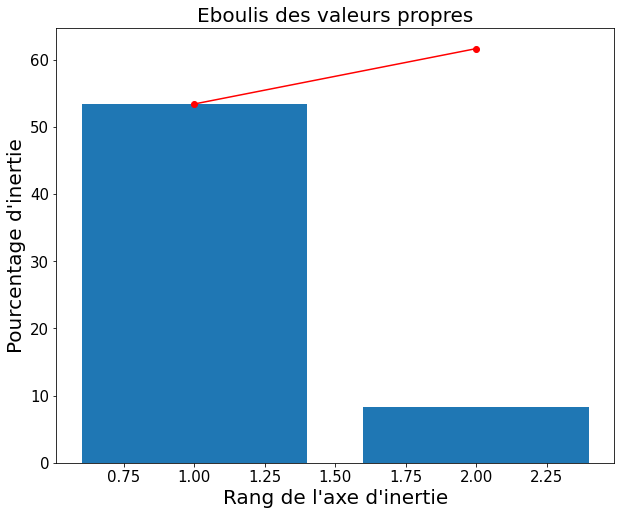

       
                                   --- PCA reduction ----


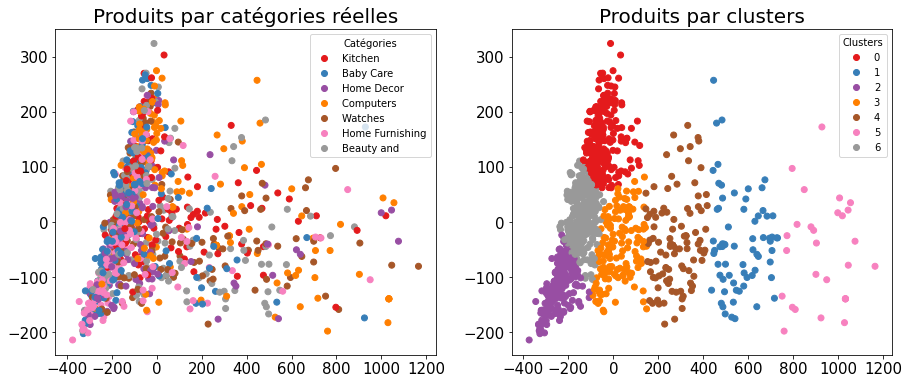

ARI :  0.0347
         
       
       
                                   --- tSNE reduction ----


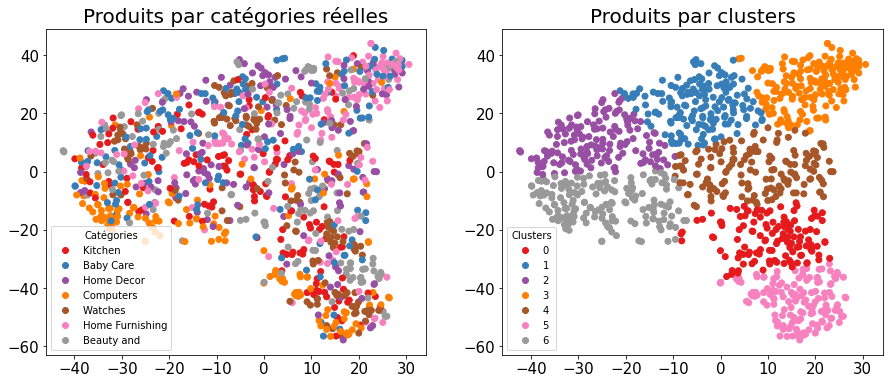

ARI :  0.0625
         
       


In [47]:
ari_IncV3 = pd.DataFrame()

Xtsne_IncV3, pca_res_IncV3 = reduc(im_features_IncV3, n_comp = 0.6)
    
print('       ')
print('                                   --- PCA reduction ----')
cl_labels_pca =  kmeans_(df, pca_res_IncV3)
ari_IncV3_pca = TSNE_visu_ARI(df, pca_res_IncV3, cl_labels_pca)
print('       ')
    
print('       ')
print('                                   --- tSNE reduction ----')
cl_labels_tsne =  kmeans_(df, Xtsne_IncV3)
ari_IncV3_tsne = TSNE_visu_ARI(df, Xtsne_IncV3, cl_labels_tsne)
print('       ')
    
ari_IncV3 = pd.DataFrame(data = {'PCA' : ari_IncV3_pca, 't-SNE' : ari_IncV3_tsne}, index = ['InceptionV3'])

# <a class="anchor" id="chapter4">IV. Bilan</a>

In [48]:
min_max(pd.concat([ari_SIFT, ari_ORB, ari_VGG16, ari_IncV3], axis = 0), 3)

,PCA,t-SNE
SIFT,0.034,0.042
ORB,0.021,0.033
VGG16,0.446,0.439
InceptionV3,0.035,0.062


En comparant les différentes méthodes de features extraction, on constate que le CNN VGG16 apporte le meilleur ARI. 

In [49]:
features_image = pd.DataFrame(data = im_features_VGG16)
features_image.to_csv('feat_image.csv', index = False)